# Clustering 3 variables datasets using K-means.

### Mateo Caro

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Importing K-means
from sklearn.cluster import KMeans
#Scaling Data
from sklearn.preprocessing import StandardScaler,normalize
#Metrics
from sklearn.metrics import davies_bouldin_score,silhouette_score



In [2]:
def reduce_memory_pd(df):
    initial_memory = df.memory_usage().sum() / (1024**2)
    print("Initial Memory Usage :",initial_memory," MB")
    NAlist = [] # Columns with NAN values. 
    for col in df.columns:
        if df[col].dtype != object:  # No strings or object           

            minimo = df[col].max()
            maximo = df[col].min()
            integer = False
            # Fill NAN with mean of the column
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(df[col].mean(),inplace=True)  
                   
            # Checking if column can be converted to integer, analyzing the residual of the substraction.
            asinteger = df[col].fillna(0).astype(np.int64)
            test_integer = (df[col] - asinteger)
            test_integer = test_integer.sum()
            if test_integer > -0.01 and test_integer < 0.001:
                integer = True

            # Convert to Int
            if integer:
                if minimo >= 0:
                    if minimo < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif minimo < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif minimo < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if minimo > np.iinfo(np.int8).min and maximo < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif minimo > np.iinfo(np.int16).min and maximo < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif minimo > np.iinfo(np.int32).min and maximo < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif minimo > np.iinfo(np.int64).min and maximo < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Convert to float32
            else:
                df[col] = df[col].astype(np.float32)
    # Print final result
        mem_usg = df.memory_usage().sum() / 1024**2 
    print("Final memory usage: ",mem_usg," MB")
    print("Final Memory Usage: ",100*mem_usg/initial_memory,"% of initial memory usage")
    return df

def info_table(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Miscoreing'] = df.isnull().sum().values    
    summary['NaN'] = df.isna().sum().values
    summary['Uniques'] = df.nunique().values
    return summary

# Importing data

In [3]:
data = pd.read_csv('../input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

# Analyzing data, consulting NaN and Null values

In [4]:
info_table(data)

Dataset Shape: (200, 5)


,Name,dtypes,Miscoreing,NaN,Uniques
0,CustomerID,int64,0,0,200
1,Gender,object,0,0,2
2,Age,int64,0,0,51
3,Annual Income (k$),int64,0,0,64
4,Spending Score (1-100),int64,0,0,84


There are no miscoreing or NaN values. It's necescoreary to delete the customerID column, because it won't be useful for clustering. It is the same case for the gender column, altough it will be used after the clustering procescore, in order to offer a better analysis of the data.

In [5]:
data.drop(["CustomerID"], axis = 1, inplace=True)
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [6]:
data.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


# Exploring data using graphs.

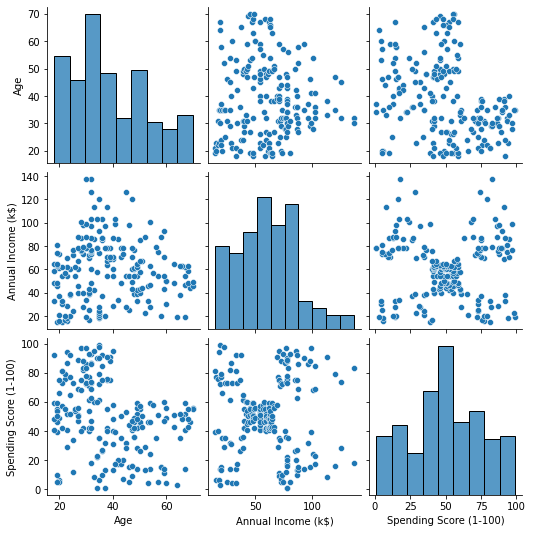

In [7]:
sns.pairplot(data)

In [8]:
data['Age']

0      19
1      21
2      20
3      23
4      31
       ..
195    35
196    45
197    32
198    32
199    30
Name: Age, Length: 200, dtype: int64

<AxesSubplot:xlabel='Age', ylabel='Count'>

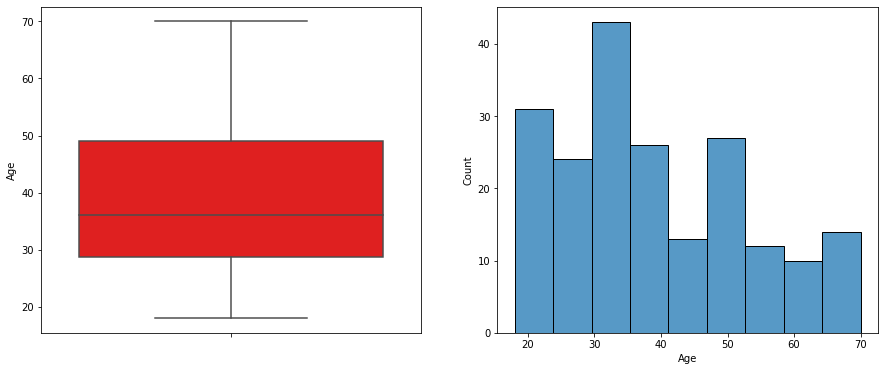

In [9]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot(y=data["Age"], color="red")
plt.subplot(1,2,2)
sns.histplot(x=data["Age"])


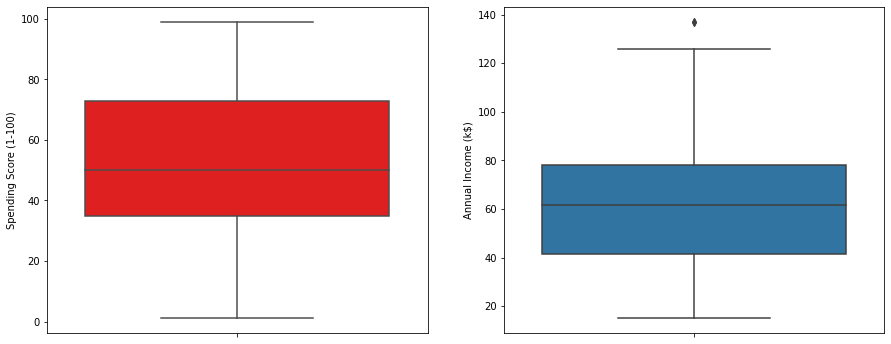

In [10]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot(y=data["Spending Score (1-100)"], color="red")
plt.subplot(1,2,2)
sns.boxplot(y=data["Annual Income (k$)"])
plt.show()

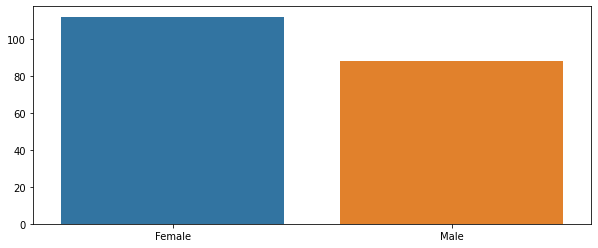

In [11]:
gender_count = data["Gender"].value_counts()
plt.figure(figsize=(10,4))
sns.barplot(x=gender_count.index, y=gender_count.values)
plt.show()

In [12]:
Gender = data.pop('Gender')

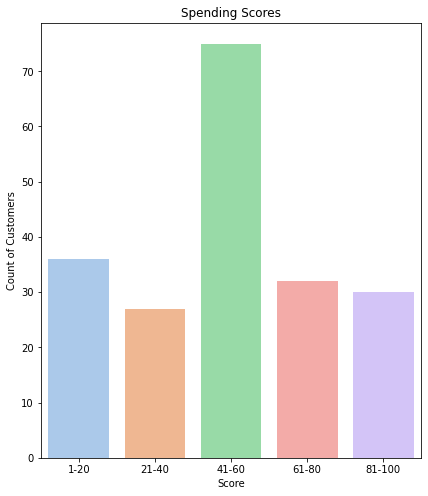

In [13]:
score1_20 = data["Spending Score (1-100)"][(data["Spending Score (1-100)"] >= 1) & (data["Spending Score (1-100)"] <= 20)]
score21_40 = data["Spending Score (1-100)"][(data["Spending Score (1-100)"] >= 21) & (data["Spending Score (1-100)"] <= 40)]
score41_60 = data["Spending Score (1-100)"][(data["Spending Score (1-100)"] >= 41) & (data["Spending Score (1-100)"] <= 60)]
score61_80 = data["Spending Score (1-100)"][(data["Spending Score (1-100)"] >= 61) & (data["Spending Score (1-100)"] <= 80)]
score81_100 = data["Spending Score (1-100)"][(data["Spending Score (1-100)"] >= 81) & (data["Spending Score (1-100)"] <= 100)]

x_labels = ["1-20", "21-40", "41-60", "61-80", "81-100"]
y_values = [len(score1_20.values), len(score21_40.values), len(score41_60.values), len(score61_80.values), len(score81_100.values)]

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.barplot(x=x_labels, y=y_values, palette="pastel")
plt.title("Spending Scores")
plt.xlabel("Score")
plt.ylabel("Count of Customers")

plt.show()

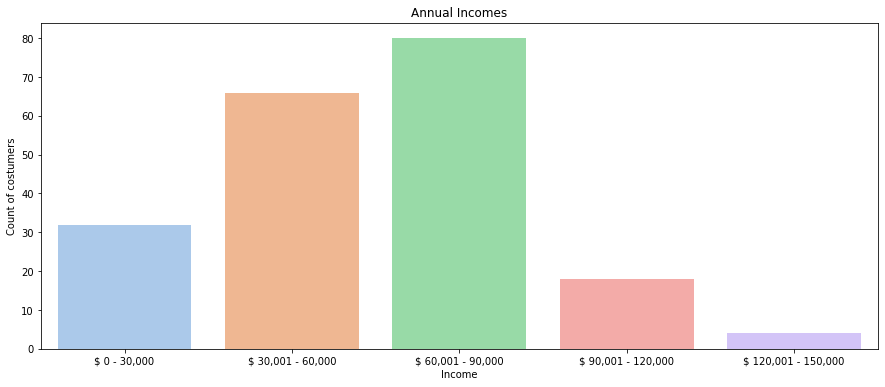

In [14]:
incomes0_30 = data["Annual Income (k$)"][(data["Annual Income (k$)"] >= 0) & (data["Annual Income (k$)"] <= 30)]
incomes31_60 = data["Annual Income (k$)"][(data["Annual Income (k$)"] >= 31) & (data["Annual Income (k$)"] <= 60)]
incomes61_90 = data["Annual Income (k$)"][(data["Annual Income (k$)"] >= 61) & (data["Annual Income (k$)"] <= 90)]
incomes91_120 = data["Annual Income (k$)"][(data["Annual Income (k$)"] >= 91) & (data["Annual Income (k$)"] <= 120)]
incomes121_150 = data["Annual Income (k$)"][(data["Annual Income (k$)"] >= 121) & (data["Annual Income (k$)"] <= 150)]

x_labels = ["$ 0 - 30,000", "$ 30,001 - 60,000", "$ 60,001 - 90,000", "$ 90,001 - 120,000", "$ 120,001 - 150,000"]
y_values = [len(incomes0_30.values), len(incomes31_60.values), len(incomes61_90.values), len(incomes91_120.values), len(incomes121_150.values)]

plt.figure(figsize=(15,6))
sns.barplot(x=x_labels, y=y_values, palette="pastel")
plt.title("Annual Incomes")
plt.xlabel("Income")
plt.ylabel("Count of costumers")
plt.show()

# Select number of k clusters 

## Using Silhouette Score and Davies Bouldin

In [15]:
db_score = []
silhou_score = []
for i in range(2,20):
    k_means=KMeans(n_clusters=i,random_state=22).fit_predict(data)
    silhou_score.append(silhouette_score(data,k_means,metric='euclidean'))
    db_score.append(davies_bouldin_score(data,k_means))

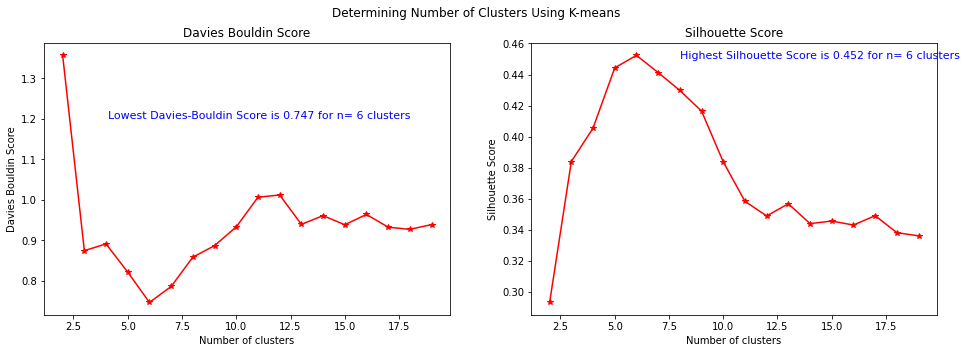

In [16]:

plt.figure(figsize=(16,5))
plt.suptitle('Determining Number of Clusters Using K-means')
plt.subplot(1,2,1)
plt.title('Davies Bouldin Score')
plt.plot(np.arange(2,20),db_score, marker='*',color='r',label='Davies Bouldin Score')
plt.xlabel('Number of clusters')
plt.ylabel('Davies Bouldin Score')
text = "Lowest Davies-Bouldin Score is {} for n= {} clusters".format(min(db_score).round(3),(db_score.index(min(db_score))+2))
plt.text(4.1, 1.2,text, fontsize=11,color='blue')
plt.subplot(1,2,2)
plt.title('Silhouette Score')
plt.plot(np.arange(2,20),silhou_score, marker='*',color='r',label='Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
text = "Highest Silhouette Score is {} for n= {} clusters".format(max(silhou_score).round(3),(silhou_score.index(max(silhou_score))+2))
plt.text(8, 0.45,text, fontsize=11,color='blue')

plt.show()


# Using K-Means for clustering

In [17]:
k_means = KMeans(n_clusters = 6,random_state=22)
clusters = k_means.fit_predict(data)
data["label"] = clusters
data['Gender'] = Gender

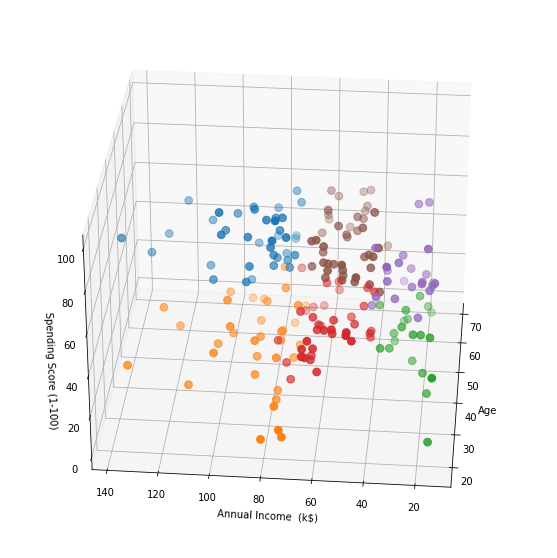

In [18]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data.Age[data.label == 0], data["Annual Income (k$)"][data.label == 0], data["Spending Score (1-100)"][data.label == 0], c='tab:blue', s=60)
ax.scatter(data.Age[data.label == 1], data["Annual Income (k$)"][data.label == 1], data["Spending Score (1-100)"][data.label == 1], c='tab:red', s=60)
ax.scatter(data.Age[data.label == 2], data["Annual Income (k$)"][data.label == 2], data["Spending Score (1-100)"][data.label == 2], c='tab:green', s=60)
ax.scatter(data.Age[data.label == 3], data["Annual Income (k$)"][data.label == 3], data["Spending Score (1-100)"][data.label == 3], c='tab:orange', s=60)
ax.scatter(data.Age[data.label == 4], data["Annual Income (k$)"][data.label == 4], data["Spending Score (1-100)"][data.label == 4], c='tab:purple', s=60)
ax.scatter(data.Age[data.label == 5], data["Annual Income (k$)"][data.label == 5], data["Spending Score (1-100)"][data.label == 5], c='tab:brown', s=60)
ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Annual Income  (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.show()

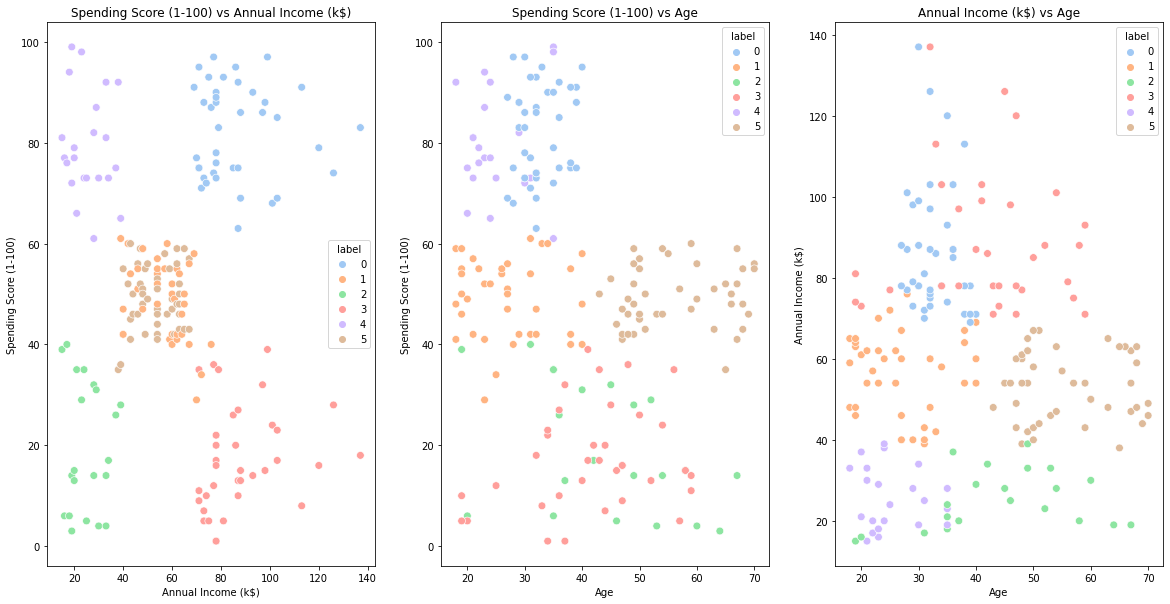

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.scatterplot(x = 'Annual Income (k$)',y = 'Spending Score (1-100)',hue="label",  
                 palette='pastel', legend='full',data = data  ,s = 60 )

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)') 
plt.title('Spending Score (1-100) vs Annual Income (k$)')
plt.subplot(1,3,2)
sns.scatterplot(x = 'Age',y = 'Spending Score (1-100)',hue="label",  
                 palette='pastel', legend='full',data = data  ,s = 60 )
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)') 
plt.title('Spending Score (1-100) vs Age')
plt.subplot(1,3,3)
sns.scatterplot(x = 'Age',y = 'Annual Income (k$)',hue="label",  
                 palette='pastel', legend='full',data = data  ,s = 60 )
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)') 
plt.title('Annual Income (k$) vs Age')

plt.show()

# Analyzing Clusters

In [20]:
grouped = data.groupby(by='label').mean().round(4)

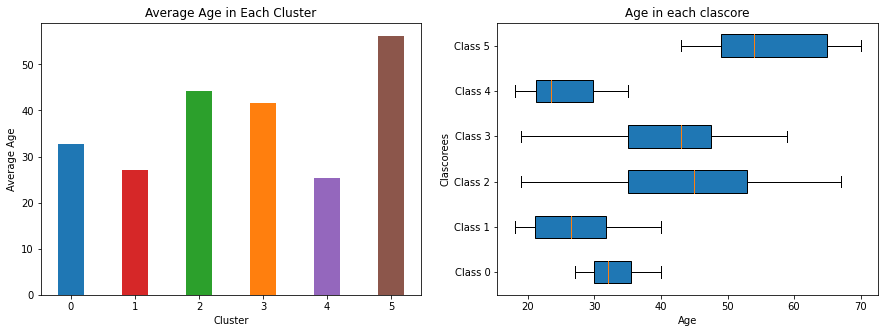

In [21]:
labels = ['Class 0','Class 1','Class 2','Class 3','Class 4','Class 5']
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple','tab:brown']
fig = plt.figure(figsize = (15, 5))
# creating the bar plot
plt.subplot(1,2,1)
plt.bar(grouped['Age'].to_dict().keys(), grouped['Age'].values,
        width = 0.4,color=colors)
plt.title("Average Age in Each Cluster")
plt.ylabel("Average Age")
plt.xlabel("Cluster")
plt.subplot(1,2,2)
age = []
for i in range(0,6):
    age.append(data[data['label']==i]['Age'].tolist())
plt.boxplot(age, vert=False, patch_artist=True, labels=labels) 
plt.ylabel('Clascorees')
plt.xlabel('Age')
plt.title('Age in each clascore')  
plt.show()


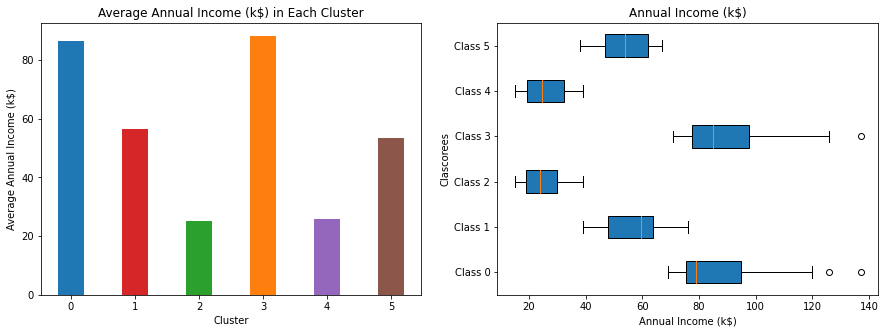

In [22]:
fig = plt.figure(figsize = (15, 5))
# creating the bar plot
plt.subplot(1,2,1)
plt.bar(grouped['Annual Income (k$)'].to_dict().keys(), grouped['Annual Income (k$)'].values,
        width = 0.4,color=colors)
plt.title("Average Annual Income (k$) in Each Cluster")
plt.ylabel("Average Annual Income (k$)")
plt.xlabel("Cluster")
plt.subplot(1,2,2)
income = []
for i in range(0,6):
    income.append(data[data['label']==i]['Annual Income (k$)'].tolist())
plt.boxplot(income, vert=False, patch_artist=True, labels=labels) 
plt.ylabel('Clascorees')
plt.xlabel('Annual Income (k$)')
plt.title('Annual Income (k$)')  

plt.show()

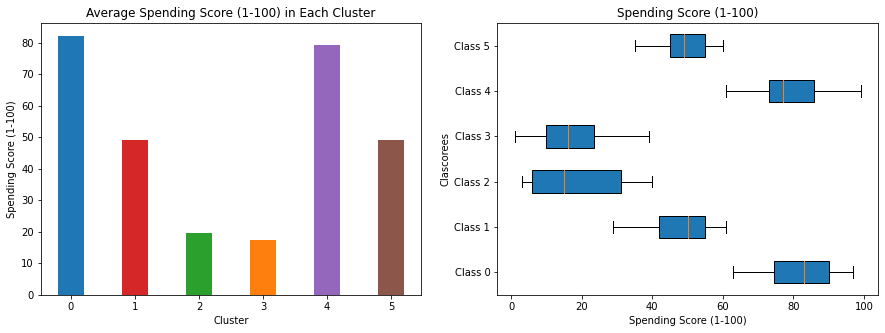

In [23]:
fig = plt.figure(figsize = (15, 5))
# creating the bar plot
plt.subplot(1,2,1)
plt.bar(grouped['Spending Score (1-100)'].to_dict().keys(), grouped['Spending Score (1-100)'].values,
        width = 0.4,color=colors)
plt.title("Average Spending Score (1-100) in Each Cluster")
plt.ylabel("Spending Score (1-100)")
plt.xlabel("Cluster")
plt.subplot(1,2,2)
spending = []
for i in range(0,6):
    spending.append(data[data['label']==i]['Spending Score (1-100)'].tolist())
plt.boxplot(spending, vert=False, patch_artist=True, labels=labels) 
plt.ylabel('Clascorees')
plt.xlabel('Spending Score (1-100)')
plt.title('Spending Score (1-100)')  
plt.show()

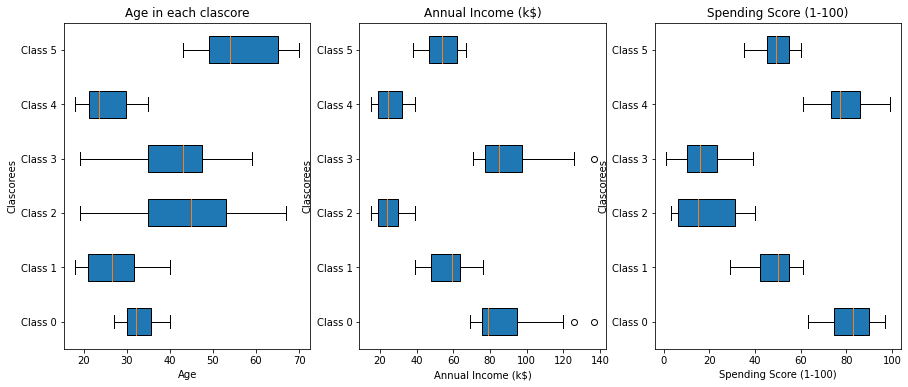

In [24]:
fig = plt.figure(figsize = (15, 6))
plt.subplot(1,3,1)
plt.boxplot(age, vert=False, patch_artist=True, labels=labels) 
plt.ylabel('Clascorees')
plt.xlabel('Age')
plt.title('Age in each clascore')  
plt.subplot(1,3,2)
plt.boxplot(income, vert=False, patch_artist=True, labels=labels) 
plt.ylabel('Clascorees')
plt.xlabel('Annual Income (k$)')
plt.title('Annual Income (k$)') 
plt.subplot(1,3,3)
plt.boxplot(spending, vert=False, patch_artist=True, labels=labels) 
plt.ylabel('Clascorees')
plt.xlabel('Spending Score (1-100)')
plt.title('Spending Score (1-100)')  
plt.show()



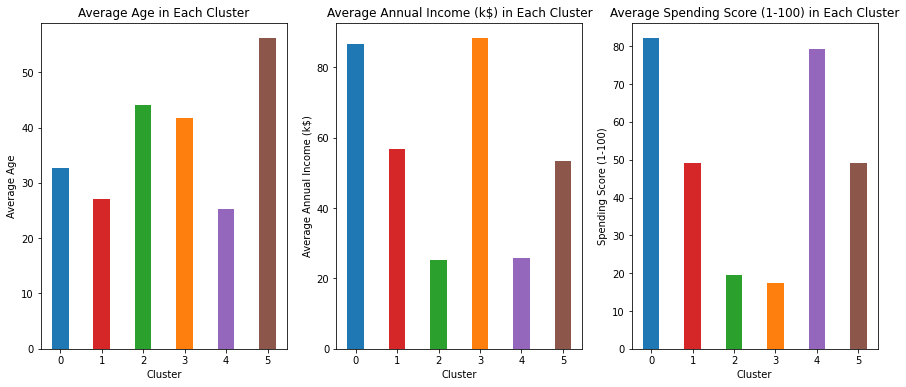

In [25]:
fig = plt.figure(figsize = (15, 6))
plt.subplot(1,3,1)
plt.bar(grouped['Age'].to_dict().keys(), grouped['Age'].values,
        width = 0.4,color=colors)
plt.title("Average Age in Each Cluster")
plt.ylabel("Average Age")
plt.xlabel("Cluster")
plt.subplot(1,3,2)
plt.bar(grouped['Annual Income (k$)'].to_dict().keys(), grouped['Annual Income (k$)'].values,
        width = 0.4,color=colors)
plt.title("Average Annual Income (k$) in Each Cluster")
plt.ylabel("Average Annual Income (k$)")
plt.xlabel("Cluster")
plt.subplot(1,3,3)
plt.bar(grouped['Spending Score (1-100)'].to_dict().keys(), grouped['Spending Score (1-100)'].values,
        width = 0.4,color=colors)
plt.title("Average Spending Score (1-100) in Each Cluster")
plt.ylabel("Spending Score (1-100)")
plt.xlabel("Cluster")
plt.show()




# Analysis and conclusions

## Class 0
* People between 18 and 40 years old. With an average of almost 30 years.
* Spending Score between 25 and 60, with an average of almost 50.
* Anual Income between 40kusd and 80kusd, with an average of almost 60kusd.

We can conclude that this class defines young and mid-age people with a decent annual income, that also have a consistent spending. score.

## Class 1
* People between 18 and 35 years old. With an average of almost 25 years.
* Spending Score between 60 and 100, with an average of almost 80.
* Anual Income between 15kusd and 40kusd, with an average of almost 25kusd.

We can conclude that this class defines young,mostly, and mid-age people with a low annual income but who also spend a lot, despite their low annual income.

## Class 2
* People between 18 and 70 years old. With an average of almost 45 years.
* Spending Score between 5 and 40, with an average of almost 20.
* Anual Income between 15kusd and 40kusd, with an average of almost 25kusd.

We can conclude that this class groups a wide range of people,according to their age, who also have a low annual income and that do not spend much

## Class 3
* People between 20 and 60 years old. With an average of almost 45 years.
* Spending Score between 5 and 40, with an average of almost 25.
* Anual Income between 70kusd and 125kusd, with an average of almost 85kusd.

We can conclude that this class groups a wide range of people,according to their age, who, despite having a high annual income,they don't spend a lot.


## Class 4
* People between 25 and 40 years old. With an average of almost 35 years.
* Spending Score between 60 and 95, with an average of almost 85.
* Anual Income between 70kusd and 120kusd, with an average of almost 85kusd.

We can conclude that this class groups a wide range of people,according to their age,who have a high annual income and who spend a lot.


## Class 5
* People between 45 and 70 years old. With an average of almost 55 years.
* Spending Score between 30 and 60, with an average of almost 50.
* Anual Income between 40kusd and 65kusd, with an average of almost 55kusd.

We can conclude that this class groups old people with a decent annual income, that also have a consistent spending

## Notes

* Taking a deep look in the graphs and according to the analysis made, the class 0 and class 5 can be merged, as they fit the same characteristics, at least in Annual Income and Spending score. The characteristic that allows to differentiate these two groups is the age, being the former the group that has a lower average age and being the latter the group of old people.

# Future Work

* Analysis including gender of each person.

# References

* https://www.kaggle.com/kushal1996/customer-segmentation-k-means-analysis
* https://github.com/muhammetbektas/Unsupervised-Learning/blob/master/Segmentation_of_Credit_Card_Users.ipynb
* https://github.com/prateekmaj21/Mall-Customer-Segementation/blob/master/Customer%20Segmentation%20(Clustering).ipynb